## Welcome

This is material for the **Regression Discontinuity** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)


In [1]:
import pandas as pd
import numpy as np
import plotnine as p
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file):
    full_path = "https://raw.github.com/scunning1975/mixtape/master/" + file
    
    return pd.read_stata(full_path)
    

## RDD Simulation

Generate a simple Regression Discontinuity, before and after the treatment is given. 

In [3]:
dat = pd.DataFrame({'x': np.random.normal(50, 25, 1000)})
dat.loc[dat.x<0, 'x'] = 0
dat = dat[dat.x<100]
dat['D'] = 0
dat.loc[dat.x>50, 'D'] = 1
dat['y1'] = 25 + 0*dat.D + 1.5 * dat.x + np.random.normal(0, 20, dat.shape[0])
dat['y2'] = 25 + 40*dat.D + 1.5 * dat.x + np.random.normal(0, 20, dat.shape[0])
print('"Counterfactual Potential Outcomes')

"Counterfactual Potential Outcomes


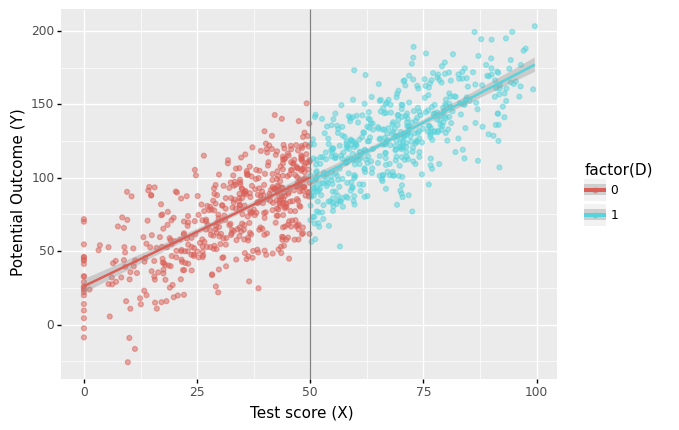

<ggplot: (8787570944627)>

In [4]:
p.ggplot(dat, p.aes(x='x', y='y1', color = 'factor(D)')) +\
    p.geom_point(alpha = 0.5) +\
    p.geom_vline(xintercept = 50, colour = "grey") +\
    p.stat_smooth(method = "lm", se = 'F') +\
    p.labs(x = "Test score (X)", y = "Potential Outcome (Y1)")

"Counterfactual Potential Outcomes after Treatment


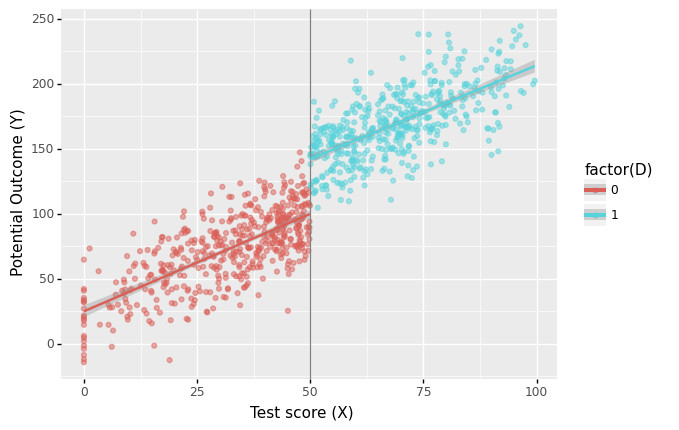

<ggplot: (8787571410505)>

In [5]:
print('"Counterfactual Potential Outcomes after Treatment')
p.ggplot(dat, p.aes(x='x', y='y2', color = 'factor(D)')) +\
    p.geom_point(alpha = 0.5) +\
    p.geom_vline(xintercept = 50, colour = "grey") +\
    p.stat_smooth(method = "lm", se = 'F') +\
    p.labs(x = "Test score (X)", y = "Potential Outcome (Y)")

In [7]:
dat = pd.DataFrame({'x': np.random.normal(100, 50, 1000)})
dat.loc[dat.x<0, 'x'] = 0
dat['x2'] = dat['x']**2
dat['x3'] = dat['x']**3
dat['D'] = 0
dat.loc[dat.x>140, 'D'] = 1

dat['y3'] = 10000 + 0*dat.D - 100 * dat.x + dat.x2 + np.random.normal(0, 1000, 1000)
dat = dat[dat.x < 280]

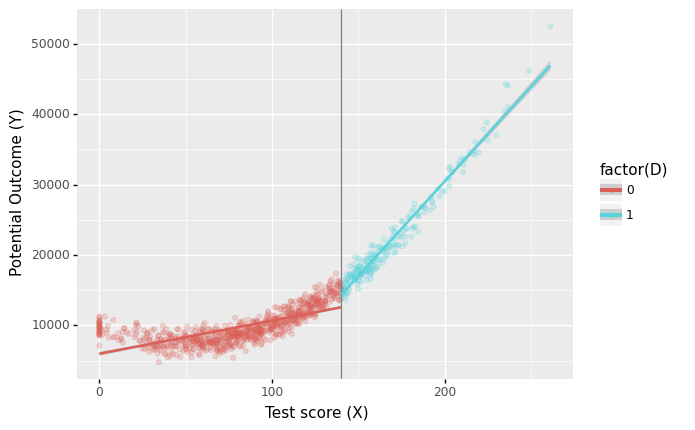

<ggplot: (8787570925797)>

In [8]:
# Linear Model for conditional expectation
p.ggplot(dat, p.aes(x='x', y='y3', color = 'factor(D)')) +\
    p.geom_point(alpha = 0.2) +\
    p.geom_vline(xintercept = 140, colour = "grey") +\
    p.stat_smooth(method = "lm", se = 'F') +\
    p.labs(x = "Test score (X)", y = "Potential Outcome (Y)")


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


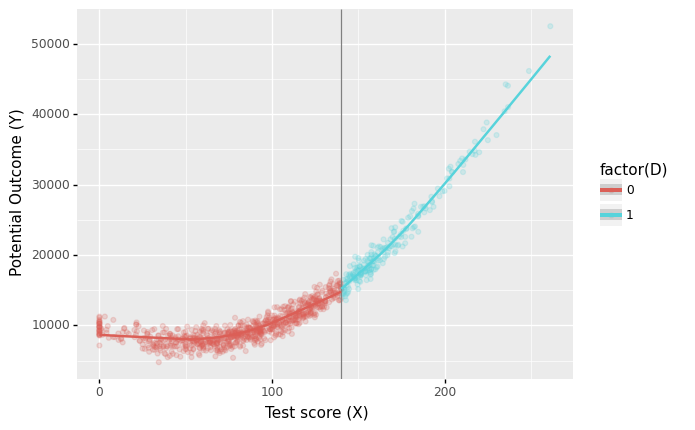

<ggplot: (8787571457958)>

In [9]:
# Linear Model for conditional expectation
p.ggplot(dat, p.aes(x='x', y='y3', color = 'factor(D)')) +\
    p.geom_point(alpha = 0.2) +\
    p.geom_vline(xintercept = 140, colour = "grey") +\
    p.stat_smooth(method = "lowess", se = 'F') +\
    p.labs(x = "Test score (X)", y = "Potential Outcome (Y)")


#### Questions
- If you estimated the treatment effect using the linear model, would your treatment effect estimate be near the true treatment effect? 



In [10]:
np.random.seed(12282020)

# Fully interacted regression
all_columns = "+".join(dat.columns.difference(["D", 'y3']))
formula = 'y3 ~ D * ({})'.format(all_columns)

regression = sm.OLS.from_formula(formula, data = dat).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     y3   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     5259.
Date:                Wed, 10 Mar 2021   Prob (F-statistic):               0.00
Time:                        18:03:20   Log-Likelihood:                -8343.0
No. Observations:                1000   AIC:                         1.670e+04
Df Residuals:                     992   BIC:                         1.674e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9679.5026    160.432     60.334      0.000    9364.677    9994.328
D          -2.179e+04    1.8e+04     -1.208      0.227   -5.72e+04    1.36e+04
x            -84.7130      8.865     -9.556      0.000    -102.108     -67.318
x2             0.8401      0.145      5.782      0.000       0.555       1.125
x3             0.0005      0.001      0.668      0.504      -0.001       0.002
D:x          327.8135    292.071      1.122      0.262    -245.335     900.962
D:x2          -1.5942      1.560     -1.022      0.307      -4.655       1.466
D:x3           0.0025      0.003      0.886      0.376      -0.003       0.008
==============================================================================
Omnibus:                        4.427   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                3.744
Skew:                           0.063   Prob(JB):                        0.154
Kurtosis:                       2.728   Cond. No.                     2.14e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Question
- What did you estimate as the treatment effect using a third order polynomial of the running variable? Is it statistically significantly different from zero?
- Does the estimated treatment effect seem correct from the graph?

## The Close Election Design

Lets load the data from Lee et. al. (2004):

In [11]:
def lm_robust(formula, data):
    regression = sm.OLS.from_formula(formula, data = data)
    regression = regression.fit(cov_type="cluster",cov_kwds={"groups":data['id']})
    return regression

In [12]:
lmb_data = read_data("lmb-data.dta")

In [13]:
lmb_data['demvoteshare_c'] = lmb_data['demvoteshare'] - 0.5
lmb_subset = lmb_data[lmb_data.lagdemvoteshare.between(.48, .52)]

In [14]:
lm_1 = lm_robust('score ~ lagdemocrat', data = lmb_subset)
lm_2 = lm_robust('score ~ democrat', data = lmb_subset)
lm_3 = lm_robust('democrat ~ lagdemocrat', data = lmb_subset)
print("Original results based on ADA Scores -- Close Elections Sample")
Stargazer([lm_1, lm_2, lm_3])

Original results based on ADA Scores -- Close Elections Sample


#### using all data (note data used is lmb_data, not lmb_subset)

In [15]:
lm_1 = lm_robust('score ~ lagdemocrat', data = lmb_data)
lm_2 = lm_robust('score ~ democrat', data = lmb_data)
lm_3 = lm_robust('democrat ~ lagdemocrat', data = lmb_data)
print("Original results based on ADA Scores -- Full Sample")
Stargazer([lm_1, lm_2, lm_3])

Original results based on ADA Scores -- Full Sample


In [19]:
# drop missing values
lmb_data = lmb_data[~pd.isnull(lmb_data.demvoteshare_c)]

In [20]:

lm_1 = lm_robust('score ~ lagdemocrat + demvoteshare_c', data = lmb_data)
lm_2 = lm_robust('score ~ democrat + demvoteshare_c', data = lmb_data)
lm_3 = lm_robust('democrat ~ lagdemocrat + demvoteshare_c', data = lmb_data)
print("Results based on ADA Scores -- Full Sample")
Stargazer([lm_1, lm_2, lm_3])

Results based on ADA Scores -- Full Sample


In [21]:
lm_1 = lm_robust('score ~ lagdemocrat*demvoteshare_c', data = lmb_data)
lm_2 = lm_robust('score ~ democrat*demvoteshare_c', data = lmb_data)
lm_3 = lm_robust('democrat ~ lagdemocrat*demvoteshare_c', data = lmb_data)
print("Original results based on ADA Scores -- Full Sample with linear interactions")
Stargazer([lm_1, lm_2, lm_3])

Original results based on ADA Scores -- Full Sample with linear interactions


In [18]:
lmb_data['demvoteshare_sq'] = lmb_data['demvoteshare_c']**2

<ipython-input-18-668d3e6ccb56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
lm_1 = lm_robust('score ~ lagdemocrat*demvoteshare_c + lagdemocrat*demvoteshare_sq', 
                 data = lmb_data)
lm_2 = lm_robust('score ~ democrat*demvoteshare_c + democrat*demvoteshare_sq', 
                 data = lmb_data)
lm_3 = lm_robust('democrat ~ lagdemocrat*demvoteshare_c + lagdemocrat*demvoteshare_sq', 
                 data = lmb_data)
print("Original results based on ADA Scores -- Full Sample with linear and quadratic interactions")
Stargazer([lm_1, lm_2, lm_3])

Original results based on ADA Scores -- Full Sample with linear and quadratic interactions


In [20]:
lmb_subset = lmb_data[lmb_data.demvoteshare.between(.45, .55)]

In [21]:
lm_1 = lm_robust('score ~ lagdemocrat*demvoteshare_c + lagdemocrat*demvoteshare_sq', 
                 data = lmb_subset)
lm_2 = lm_robust('score ~ democrat*demvoteshare_c + democrat*demvoteshare_sq', 
                 data = lmb_subset)
lm_3 = lm_robust('democrat ~ lagdemocrat*demvoteshare_c + lagdemocrat*demvoteshare_sq', 
                 data = lmb_subset)
print("Results based on ADA Scores -- Close Sample with linear and quadratic interactions")
Stargazer([lm_1, lm_2, lm_3])

Results based on ADA Scores -- Close Sample with linear and quadratic interactions


<ipython-input-22-75fbc0c4726e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-22-75fbc0c4726e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 39 rows containing missing values.


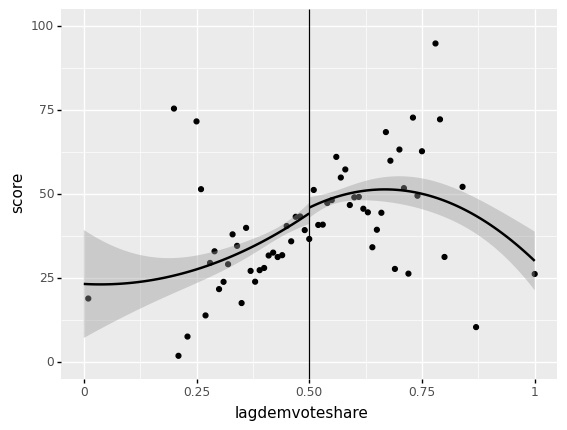

<ggplot: (8787543048361)>

In [22]:
#aggregating the data
lmb_data = lmb_data[lmb_data.demvoteshare.between(.45, .55)]
categories = lmb_data.lagdemvoteshare
lmb_data['lagdemvoteshare_100'] = pd.cut(lmb_data.lagdemvoteshare, 100)

agg_lmb_data = lmb_data.groupby('lagdemvoteshare_100')['score'].mean().reset_index()
lmb_data['gg_group'] = [1 if x>.5 else 0 for x in lmb_data.lagdemvoteshare]
agg_lmb_data['lagdemvoteshare'] = np.arange(0.01, 1.01, .01)
#plotting

p.ggplot(lmb_data, p.aes('lagdemvoteshare', 'score')) +\
    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data) +\
    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data, method = "lm", 
              formula = 'y ~ x + I(x**2)') +\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 39 rows containing missing values.


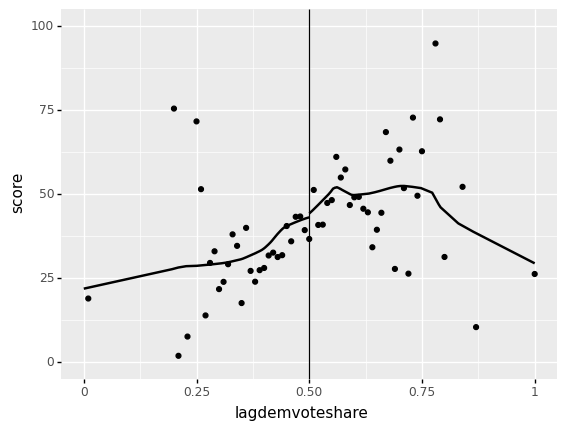

<ggplot: (8787543051156)>

In [23]:
p.ggplot(lmb_data, p.aes('lagdemvoteshare', 'score')) +\
    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data) +\
    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data, method = "lowess") +\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 39 rows containing missing values.


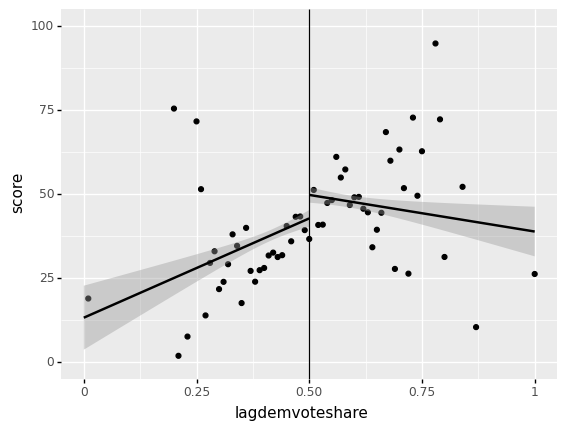

<ggplot: (8787541846797)>

In [24]:
p.ggplot(lmb_data, p.aes('lagdemvoteshare', 'score')) +\
    p.geom_point(p.aes(x = 'lagdemvoteshare', y = 'score'), data = agg_lmb_data) +\
    p.stat_smooth(p.aes('lagdemvoteshare', 'score', group = 'gg_group'), 
                  data=lmb_data, method = "lm")+\
    p.xlim(0,1) + p.ylim(0,100) +\
    p.geom_vline(xintercept = 0.5)

## Smoothing and Density [WIP]

#### Questions
- Can you think of another example where you might use the close election design to estimate some average treatment effect?
- To what degree does this study help us understand the importance of incumbency in a Presidential election?  Why/why not?